# **Importar bibliotecas**

In [3]:
# Bibliotecas necesarias
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Bibliotecas de Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Configuración para gráficos
sns.set(style="whitegrid")
%matplotlib inline

# **Generación del Dataset (Punto 0)**

In [4]:
# --- Generación de Datos (Basado en generate_csv.py) ---

# Elegir una semilla aleatoria dentro de un rango
seed = random.randint(30, 50)
np.random.seed(seed)
print(f"Usando semilla aleatoria: {seed}")

n = random.randint(60000, 65000) #

# Generar variables
temperatura = np.random.normal(loc=22, scale=5, size=n)
personas = np.random.randint(1, 6, size=n).astype(float)
electrodomesticos = np.random.randint(5, 21, size=n).astype(float)

# Calcular consumo con algo de ruido
consumo = (temperatura * 0.85 + personas * 3.2 + electrodomesticos * 1.7 +
           np.random.normal(0, 3, n))

# Introducir NaNs aleatorios (~5%)
for col in [temperatura, personas, electrodomesticos, consumo]:
    idx_nan = np.random.choice(n, size=int(n * 0.05), replace=False)
    col[idx_nan] = np.nan

# Introducir outliers en el consumo (~1%)
outlier_idx = np.random.choice(n, size=int(n * 0.01), replace=False)
consumo[outlier_idx] += np.random.normal(100, 20, size=len(outlier_idx))

# Crear DataFrame
df_gen = pd.DataFrame({
    'Temperatura': temperatura,
    'Personas': personas,
    'Electrodomesticos': electrodomesticos,
    'Consumo_kWh': consumo
})

# --- Guardar el archivo CSV (Punto 0) ---
df_gen.to_csv('consumo_hogar.csv', index=False) #

print(f"Archivo 'consumo_hogar.csv' generado con éxito ({len(df_gen)} filas).")

Usando semilla aleatoria: 41
Archivo 'consumo_hogar.csv' generado con éxito (61584 filas).


# **Carga y Análisis Inicial (Punto 1)**

In [5]:
# Cargar el archivo .csv en un DataFrame
df = pd.read_csv('consumo_hogar.csv') #

# Visualizar primeras filas [cite: 16]
print("--- 1. Visualización con .head() ---")
print(df.head())
print("\n")

# Explorar tipos de datos y nulos
print("--- 2. Exploración con .info() ---")
df.info()
print("\n")

# Obtener estadísticos básicos
print("--- 3. Estadísticos con .describe() ---")
print(df.describe())
print("\n")

# Conteo específico de valores nulos
print("--- 4. Conteo de Nulos por Columna ---")
print(df.isnull().sum())

--- 1. Visualización con .head() ---
   Temperatura  Personas  Electrodomesticos  Consumo_kWh
0    20.646438       1.0               18.0    48.470057
1    22.524240       4.0               19.0    64.002486
2    23.252639       4.0               11.0    49.346845
3    17.374000       5.0               16.0    62.168064
4    24.835718       5.0               11.0    59.254880


--- 2. Exploración con .info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61584 entries, 0 to 61583
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperatura        58505 non-null  float64
 1   Personas           58505 non-null  float64
 2   Electrodomesticos  58505 non-null  float64
 3   Consumo_kWh        58505 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB


--- 3. Estadísticos con .describe() ---
        Temperatura      Personas  Electrodomesticos   Consumo_kWh
count  58505.000000  58505.000000      

# **Limpieza de Datos - Nulos (Punto 2)**

In [6]:
print("Iniciando limpieza de datos...")

# Copiamos el dataframe para mantener el original
df_clean = df.copy()

# 1. Tratamiento de Valores Nulos (NaN)
# Usaré la mediana para la imputación, ya que es más robusta a outliers
# que la media (promedio).
imputer = SimpleImputer(strategy='median')

# Aplicamos el imputer a todas las columnas
df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

print("--- Conteo de Nulos (Después de Imputación) ---")
print(df_clean.isnull().sum())
print("Valores nulos imputados con éxito.")

Iniciando limpieza de datos...
--- Conteo de Nulos (Después de Imputación) ---
Temperatura          0
Personas             0
Electrodomesticos    0
Consumo_kWh          0
dtype: int64
Valores nulos imputados con éxito.


# **Limpieza de Datos - Outliers (Punto 2)**

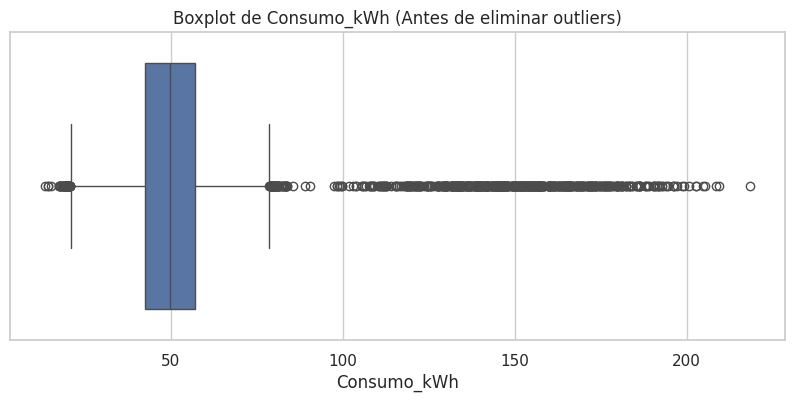

Filas originales (post-imputación): 61584
Filas eliminadas como outliers: 585
Filas restantes: 60999


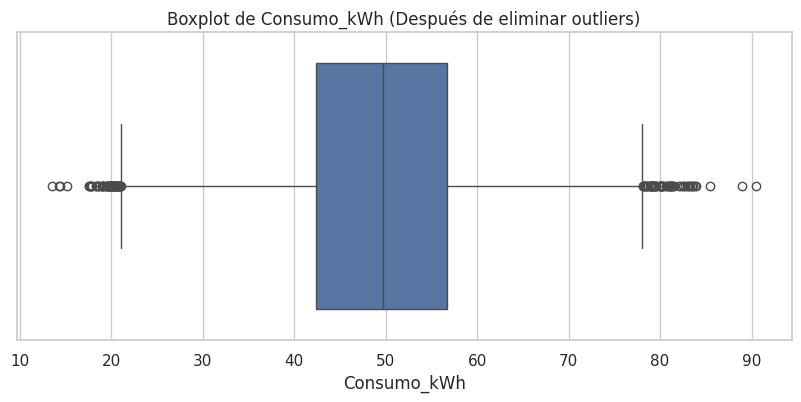

In [7]:
# 2. Detección y Eliminación de Outliers

# Visualización ANTES de eliminar outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_clean['Consumo_kWh'])
plt.title('Boxplot de Consumo_kWh (Antes de eliminar outliers)')
plt.savefig('boxplot_antes_outliers.png')
plt.show()

# Calcular Z-score para Consumo_kWh
df_clean['Consumo_Z'] = np.abs(zscore(df_clean['Consumo_kWh']))

# Definimos un umbral de 3 (3 desviaciones estándar)
threshold = 3
filas_originales = len(df_clean)

# Filtramos el DataFrame, eliminando outliers
# (Cumpliendo la instrucción "eliminar los outliers")
df_no_outliers = df_clean[df_clean['Consumo_Z'] <= threshold].copy()

filas_eliminadas = filas_originales - len(df_no_outliers)
print(f"Filas originales (post-imputación): {filas_originales}")
print(f"Filas eliminadas como outliers: {filas_eliminadas}")
print(f"Filas restantes: {len(df_no_outliers)}")

# Eliminamos la columna Z-score auxiliar
df_no_outliers = df_no_outliers.drop(columns=['Consumo_Z'])

# Visualización DESPUÉS de eliminar outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_no_outliers['Consumo_kWh'])
plt.title('Boxplot de Consumo_kWh (Después de eliminar outliers)')
plt.savefig('boxplot_despues_outliers.png')
plt.show()

# **Visualización Exploratoria (Punto 3)**

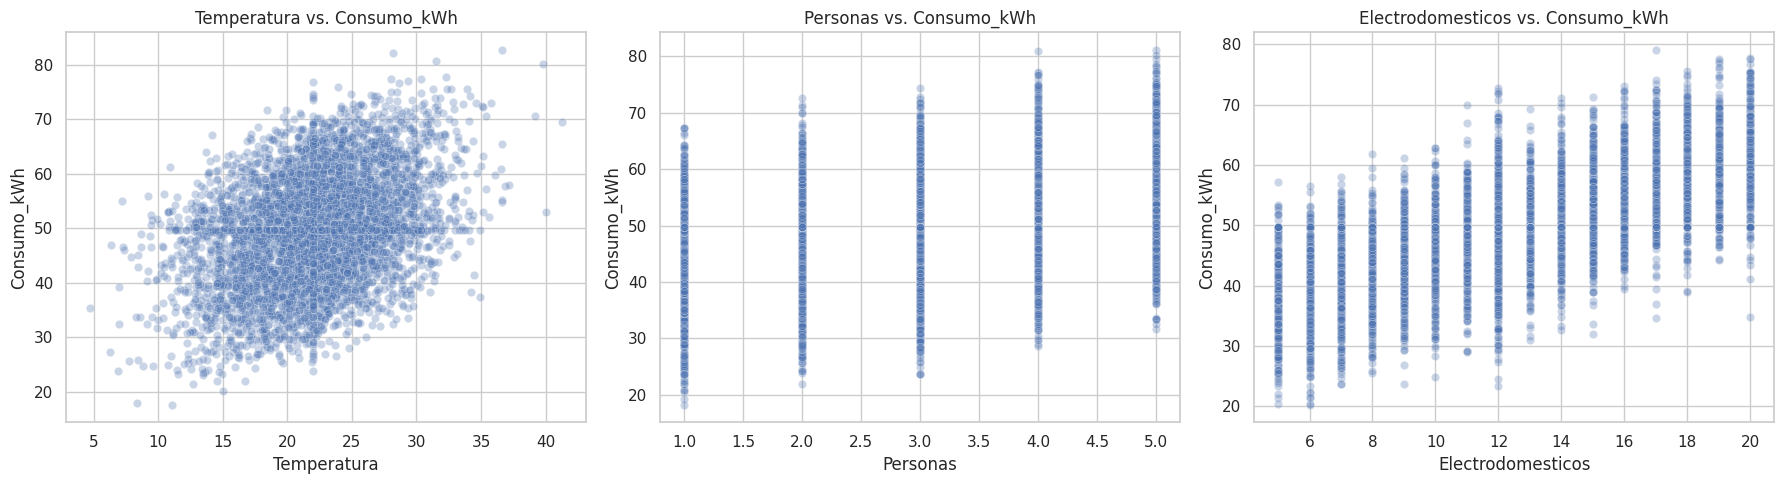

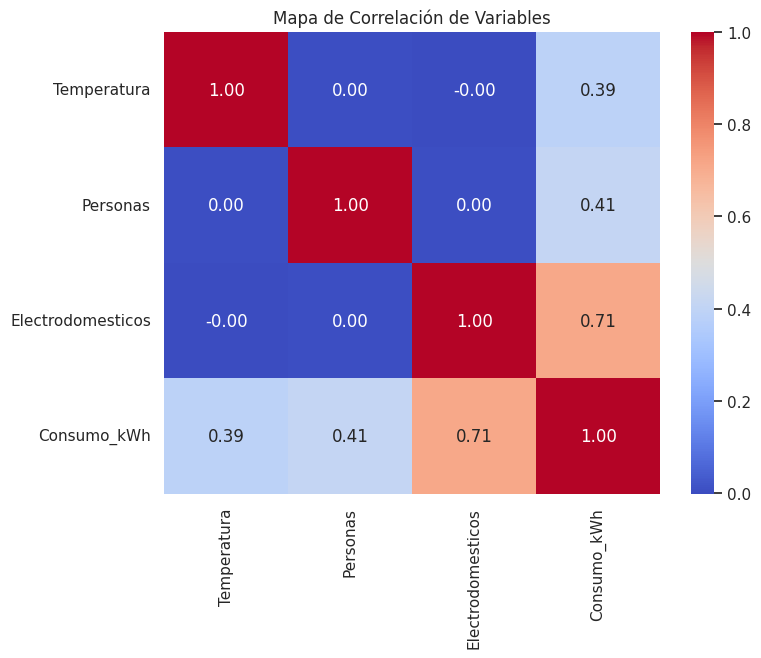

In [8]:
# Gráficos de dispersión (scatterplot)
variables_independientes = ['Temperatura', 'Personas', 'Electrodomesticos']
plt.figure(figsize=(18, 5))

for i, col in enumerate(variables_independientes):
    plt.subplot(1, 3, i + 1)
    # Usamos .sample(5000) para aligerar el gráfico si el dataset es muy grande
    sns.scatterplot(data=df_no_outliers.sample(min(5000, len(df_no_outliers))),
                    x=col, y='Consumo_kWh', alpha=0.3)
    plt.title(f'{col} vs. Consumo_kWh')

plt.tight_layout()
plt.savefig('scatter_plots_exploratorios.png')
plt.show()

# Mapa de correlación (Extra, muy útil)
plt.figure(figsize=(8, 6))
correlation_matrix = df_no_outliers.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlación de Variables')
plt.savefig('correlation_heatmap.png')
plt.show()

# **Preparación para Modelado**

In [9]:
# Definir variables independientes (X) y dependiente (y)
X = df_no_outliers.drop('Consumo_kWh', axis=1)
y = df_no_outliers['Consumo_kWh']

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las variables (features)
# Es crucial escalar para que los coeficientes sean comparables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Forma de X_train (escalado): {X_train_scaled.shape}")
print(f"Forma de X_test (escalado): {X_test_scaled.shape}")

Forma de X_train (escalado): (48799, 3)
Forma de X_test (escalado): (12200, 3)


# **Modelado - Regresión Lineal Múltiple (Punto 4a)**

In [10]:
print("--- Entrenando Regresión Lineal Múltiple (MLR) ---")

# 1. Crear y entrenar el modelo
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train) #

# 2. Mostrar coeficientes e intercepto [cite: 29]
print(f"\nIntercepto (b0): {mlr.intercept_:.4f}")
print("Coeficientes (b1, b2, b3):")
for i, col in enumerate(X.columns):
    print(f"  {col}: {mlr.coef_[i]:.4f}")

# 3. Realizar predicciones
y_pred_mlr = mlr.predict(X_test_scaled)

# 4. Calcular métricas
mse_mlr = mean_squared_error(y_test, y_pred_mlr) #
r2_mlr = r2_score(y_test, y_pred_mlr) #

print(f"\nMétricas para MLR:")
print(f"  MSE (Error Cuadrático Medio): {mse_mlr:.4f}")
print(f"  R² (Coeficiente de Determinación): {r2_mlr:.4f}")

--- Entrenando Regresión Lineal Múltiple (MLR) ---

Intercepto (b0): 49.5617
Coeficientes (b1, b2, b3):
  Temperatura: 3.9865
  Personas: 4.1867
  Electrodomesticos: 7.2842

Métricas para MLR:
  MSE (Error Cuadrático Medio): 18.0358
  R² (Coeficiente de Determinación): 0.8257


# **Modelado - Regresión Polinómica Grado 2 (Punto 4b)**

In [11]:
print("--- Entrenando Regresión Polinómica (Grado 2) ---")

# 1. Crear características polinómicas (Grado 2)
poly_features_2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_2 = poly_features_2.fit_transform(X_train_scaled)
X_test_poly_2 = poly_features_2.transform(X_test_scaled)

print(f"Número de features originales: {X_train_scaled.shape[1]}")
print(f"Número de features polinómicas (Grado 2): {X_train_poly_2.shape[1]}")

# 2. Entrenar el modelo de regresión lineal con las nuevas features [cite: 32]
model_poly_2 = LinearRegression()
model_poly_2.fit(X_train_poly_2, y_train)

# 3. Realizar predicciones
y_pred_poly_2 = model_poly_2.predict(X_test_poly_2)

# 4. Calcular métricas
mse_poly_2 = mean_squared_error(y_test, y_pred_poly_2) #
r2_poly_2 = r2_score(y_test, y_pred_poly_2) #

print(f"\nMétricas para Polinómica (Grado 2):")
print(f"  MSE: {mse_poly_2:.4f}")
print(f"  R²: {r2_poly_2:.4f}")

--- Entrenando Regresión Polinómica (Grado 2) ---
Número de features originales: 3
Número de features polinómicas (Grado 2): 9

Métricas para Polinómica (Grado 2):
  MSE: 18.0345
  R²: 0.8257


# **Modelado - Regresión Polinómica Grado 3 (Punto 4b)**

In [12]:
print("--- Entrenando Regresión Polinómica (Grado 3) ---")

# 1. Crear características polinómicas (Grado 3)
poly_features_3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly_3 = poly_features_3.fit_transform(X_train_scaled)
X_test_poly_3 = poly_features_3.transform(X_test_scaled)

print(f"Número de features polinómicas (Grado 3): {X_train_poly_3.shape[1]}")

# 2. Entrenar el modelo de regresión lineal [cite: 32]
model_poly_3 = LinearRegression()
model_poly_3.fit(X_train_poly_3, y_train)

# 3. Realizar predicciones
y_pred_poly_3 = model_poly_3.predict(X_test_poly_3)

# 4. Calcular métricas
mse_poly_3 = mean_squared_error(y_test, y_pred_poly_3) #
r2_poly_3 = r2_score(y_test, y_pred_poly_3) #

print(f"\nMétricas para Polinómica (Grado 3):")
print(f"  MSE: {mse_poly_3:.4f}")
print(f"  R²: {r2_poly_3:.4f}")

--- Entrenando Regresión Polinómica (Grado 3) ---
Número de features polinómicas (Grado 3): 19

Métricas para Polinómica (Grado 3):
  MSE: 18.0324
  R²: 0.8257


# **Evaluación y Comparación (Punto 5)**

--- Tabla Comparativa de Modelos ---
| Modelo                         |     MSE |     R² |
|:-------------------------------|--------:|-------:|
| Regresión Lineal Múltiple      | 18.0358 | 0.8257 |
| Regresión Polinómica (Grado 2) | 18.0345 | 0.8257 |
| Regresión Polinómica (Grado 3) | 18.0324 | 0.8257 |


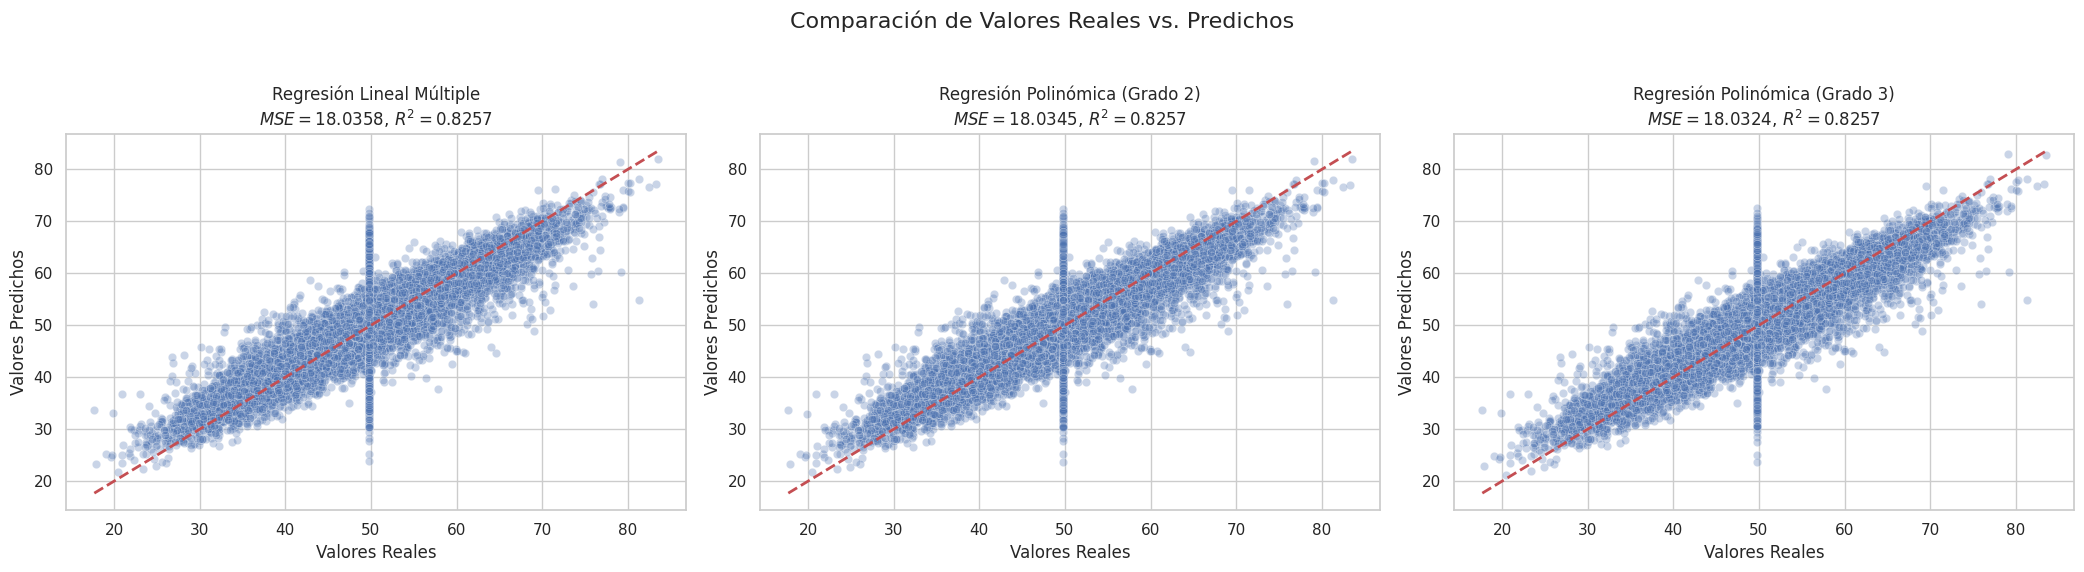

In [16]:
# 1. Crear tabla comparativa de métricas
results_data = {
    'Modelo': ['Regresión Lineal Múltiple', 'Regresión Polinómica (Grado 2)', 'Regresión Polinómica (Grado 3)'],
    'MSE': [mse_mlr, mse_poly_2, mse_poly_3],
    'R²': [r2_mlr, r2_poly_2, r2_poly_3]
}
results_df = pd.DataFrame(results_data)

print("--- Tabla Comparativa de Modelos ---")
# Usamos .to_markdown para una bonita impresión
print(results_df.to_markdown(index=False, floatfmt=".4f"))


# 2. Graficar valores predichos vs. reales [cite: 41]
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle('Comparación de Valores Reales vs. Predichos', fontsize=16)

# Gráfico 1: MLR
sns.scatterplot(ax=axes[0], x=y_test, y=y_pred_mlr, alpha=0.3)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title(f'Regresión Lineal Múltiple\n$MSE = {mse_mlr:.4f}$, $R^2 = {r2_mlr:.4f}$')
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Valores Predichos')

# Gráfico 2: Polinómica Grado 2
sns.scatterplot(ax=axes[1], x=y_test, y=y_pred_poly_2, alpha=0.3)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title(f'Regresión Polinómica (Grado 2)\n$MSE = {mse_poly_2:.4f}$, $R^2 = {r2_poly_2:.4f}$')
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Valores Predichos')

# Gráfico 3: Polinómica Grado 3
sns.scatterplot(ax=axes[2], x=y_test, y=y_pred_poly_3, alpha=0.3)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_title(f'Regresión Polinómica (Grado 3)\n$MSE = {mse_poly_3:.4f}$, $R^2 = {r2_poly_3:.4f}$')
axes[2].set_xlabel('Valores Reales')
axes[2].set_ylabel('Valores Predichos')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('comparacion_predicciones.png')
plt.show()